# Heart Disease (Cleveland)

### Table of Contents

- [Introduction](#Introduction)
- [Methods](#Methods)
    - [Preliminatory Data Exploration](#Preliminatory-Data-Exploration)
    - [Building the Predictive Model](#Building-the-Model)
- [Results](#Visualization-of-Results)
- [Discussion](#Discussion)
- [References](#References)

# Introduction

Heart disease is a term used to describe a number of heart conditions, including a heart attack, an arrhythmia or heart failure. There are many symptoms for heart disease, specifically many symptoms that go unnoticed, and therefore at times it can be difficult to diagnose. What this project aims to do is to predict the presence of heart disease for a patient based on two numerical variables. We chose to use the Heart Disease dataset provided by the course, specifically the Cleveland segment. The variables that we found were the most accurate predictors were [ST depression](#ST-Depression) and [maximum heart rate](#Maximum-Heart-Rate). Answering this question with these variables could signify a new way to predict heart disease using data, and possibly saving lives. 

# Methods

## Preliminatory Data Exploration

### 1. Reading and Wrangling Data 

#### Load Libraries 

In [1]:
#Load required library
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Reading in Heart Disease Data

- Here, it is best to use URL since dataset can be read from the internet to enable reading without local file 
- Column names were added for clarity since the dataset does not contain column headers

In [2]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = FALSE) |>
    rename(age      = X1,      # Age in years
           sex      = X2,      # Sex (1 = male, 0 = female)
           cp       = X3,      # Chest pain type 
                               # - 1 : typical angina
                               # - 2 : atypical angina
                               # - 3 : non-anginal pain
                               # - 4 : asymptomatic
           trestbps = X4,      # Resting blood pressure (mmHg)
           chol     = X5,      # Serum cholestoral (mg/dL)
           fbs      = X6,      # Fasting blood sugar > 120 mg/dL (1 = true, 0 = false)
           restecg  = X7,      # Resting electrocardiographic results 
                               # - 0 : normal,
                               # - 1 : having ST-T wave abnormality (T wave inversions and/or ST 
                               #       elevation or depression of > 0.05 mV)
                               # - 2 : showing probable or definite left ventricular hypertrophy by Estes' criteria
           thalach  = X8,      # Maximum heart rate achieved
           exang    = X9,      # Exercise induced angina (0 = no, 1 = yes)
           oldpeak  = X10,     # ST depression induced by exercise relative to rest
           slope    = X11,     # The slope of the peak exercise ST segment
                               # - 1 : upsloping
                               # - 2 : flat
                               # - 3 : downsloping
           ca       = X12,     # Number of major vessels (0-3) colored by flourosopy
           thal     = X13,     # 3 = normal; 6 = fixed defect; 7 = reversable defect
           num      = X14)     # diagnosis of heart disease (angiographic disease status)
print("Table 1.1 - Cleveland Data With Column Names")
cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1.1 - Cleveland Data With Column Names"


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


#### Data wrangling

- Categorical varaibles are mutated to factor as required by classificaiton.
- Since we are predicting presence, a column of presence was added by mutating any number of heart disease class (the category num) above 0 to signify the presence of heart disease is true.

In [3]:
#Convert columns to sensible data types
cleveland_data <- cleveland_data |>
    mutate(age      = as.integer(age),
           sex      = as.factor(sex),
           cp       = as.factor(cp),
           trestbps = as.integer(trestbps),
           chol     = as.integer(chol),
           fbs      = as.factor(fbs),
           restecg  = as.factor(restecg),
           thalach  = as.double(thalach),
           exang    = as.factor(exang),
           oldpeak  = as.double(oldpeak),
           slope    = as.factor(slope),
           ca       = as.integer(ca),
           thal     = as.factor(thal),
           num      = as.factor(num)) 

# Creating a new column which is whether or not a person has presence of heart disease
cleveland_data <- cleveland_data |>
    mutate(presence = (num != 0)) |>    
    mutate(presence = as.factor(presence))

print("Table 1.2- Heart Disease Variables (Cleveland Dataset)")
cleveland_data


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


[1] "Table 1.2- Heart Disease Variables (Cleveland Dataset)"


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,presence
<int>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3,TRUE
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1,TRUE
38,1,3,138,175,0,0,173,0,0.0,1,NA,3.0,0,FALSE


### 2. Splitting Data 
- proportion of 75% of data assigned to the training dataset and 25% to the testing dataset
- seed was used to ensure consistenly reproducible results despite randomness of initial_split()

In [4]:
#Setting random seed
set.seed(8205)
# Splitting the data into training and testing sets
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split) 
cleveland_testing <- testing(cleveland_split)

### 3. Summarize  Dataset

- We have quantified the amount of patients with or without heart disease by grouping by presence and summarizing their count

In [5]:
target_summary <- cleveland_training |>
    group_by(presence) |>
    summarize(count = n())

print("Table 3.1 - Summary of Presence (or not) of Heart Disease and how many patients")
target_summary

[1] "Table 3.1 - Summary of Presence (or not) of Heart Disease and how many patients"


presence,count
<fct>,<int>
FALSE,123
TRUE,103


- The count of true or false presence is represented graphically using a bar plot to visualize the different amounts of patients in each category.

[1] "Figure 3.2 - Summary of Presence (or not) of Heart Disease and how many patients"


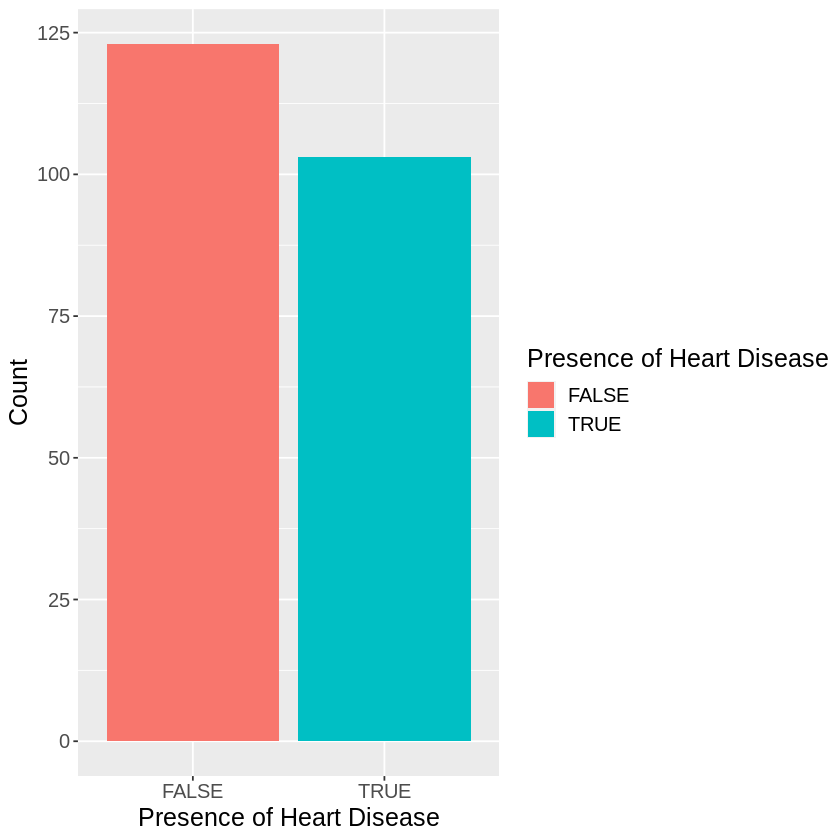

In [6]:
target_summary_plot <- target_summary |>
    ggplot(aes(x = presence, y = count, fill = presence)) +
    geom_bar(stat = "identity") +
    labs(x = "Presence of Heart Disease", y = "Count", fill = "Presence of Heart Disease") +
    theme(text = element_text(size = 15))

print("Figure 3.2 - Summary of Presence (or not) of Heart Disease and how many patients")
target_summary_plot

From the dataset, the majority of patients do not have any presence of heart disease.

#### Demographics

- Here we chose to analyze the amount of patients between sex and quantify the average age of the patients to see the degree of representation the sample size holds. 

In [7]:
demographic_summary <- cleveland_training |>
    group_by(sex) |>
    summarize(count = n(), average_age = mean(age))

print("Table 3.3 -  Presence of Heart Disease count for male (1) and female (0) patients, as well as average age of occurence")
demographic_summary

[1] "Table 3.3 -  Presence of Heart Disease count for male (1) and female (0) patients, as well as average age of occurence"


sex,count,average_age
<fct>,<int>,<dbl>
0,73,56.06849
1,153,53.66667


- We can see here that there are many more males than females in this dataset, which could effect the results of our predicting model. 
- The quantification of sex is represented with a bar graph below, as well as the distribution of age visualized using a histogram graph. 

[1] "Figure 3.4 Count of presence of Heart Disease in Male vs. Female patients"


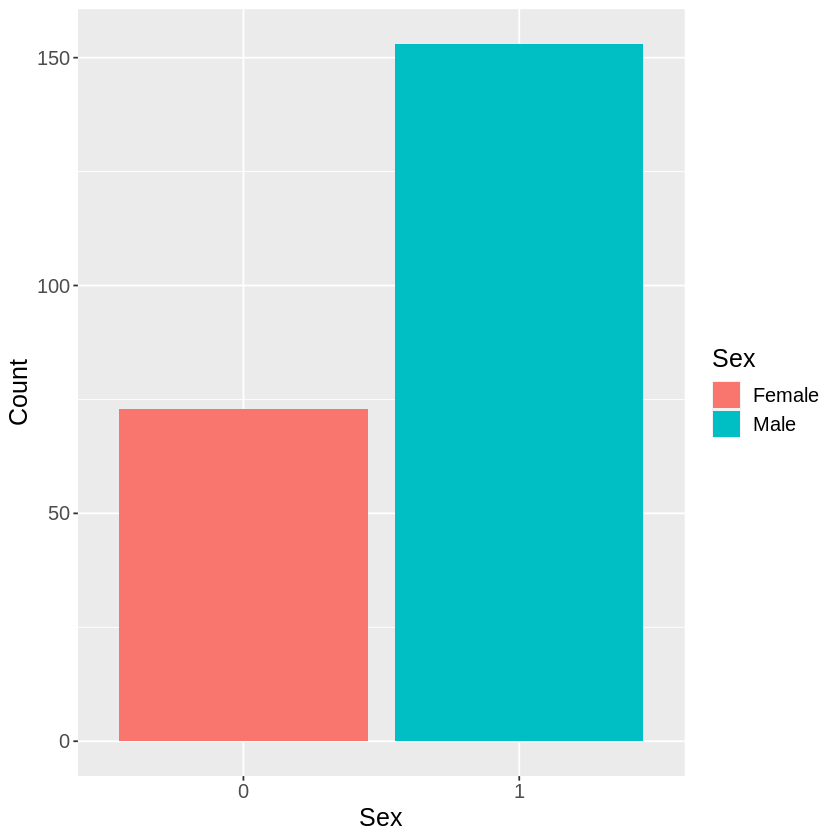

[1] "Figure 3.5 Count of presence of Heart Disease by age in Male and Femal patients"


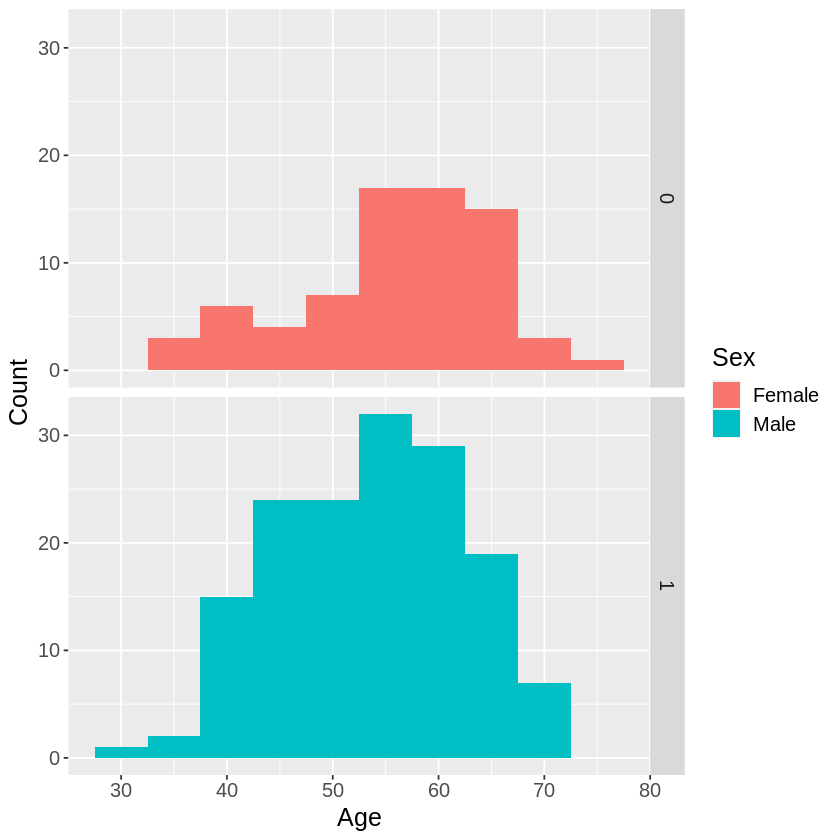

In [8]:
demographic_sex_summary_plot <- demographic_summary |>
    ggplot(aes(x =  sex, y = count, fill = sex)) +
    geom_bar(stat = "identity") +
    labs(x = "Sex", y = "Count", fill = "Sex") +
    scale_fill_discrete(labels = c("Female", "Male")) +
    theme(text = element_text(size = 15))

demographic_age_summary_plot <- cleveland_training |>
    ggplot(aes(x =  age, fill = sex)) +
    geom_histogram(binwidth = 5) +
    labs(x = "Age", y =  "Count", fill = "Sex") +
    scale_fill_discrete(labels = c("Female", "Male")) +
    facet_grid(rows = vars(sex)) +
    theme(text = element_text(size = 15))

demographic_sex_summary_plot
print("Figure 3.4 Count of presence of Heart Disease in Male vs. Female patients")
demographic_age_summary_plot
print("Figure 3.5 Count of presence of Heart Disease by age in Male and Femal patients")

The number of male double that of female participants. The average age for this dataset is around 54 years old. In addition, the average age of the male is slightly younger than female participants.

### 4. Summary of Predicting Variables

#### Maximum Heart Rate

- To see if this variale can signify the presence of heart disease, we want to see the difference in average maximum heart rate between true and false presence of heart disease. 
- To do this, we grouped by the presence and took the average as seen in Table 4.1 

In [9]:
average_thalach <- cleveland_training |>
    summarize(average_thalach = mean(thalach))

average_thalach_by_type <- cleveland_training |>
    group_by(presence) |>
    summarize(average_thalach = mean(thalach))
print(" Table 4.1 - Average Max Heart Rate within presence")  
average_thalach_by_type
print(" Table 4.2 - Average Max Heart Rate overall")  
average_thalach

[1] " Table 4.1 - Average Max Heart Rate within presence"


presence,average_thalach
<fct>,<dbl>
FALSE,158.4309
TRUE,138.8058


[1] " Table 4.2 - Average Max Heart Rate overall"


average_thalach
<dbl>
149.4867


The average maximum heart rate achieved for this dataset is 149.5 *bpm*. Healthy people, on average, have much lower maximum heart rate compared to the sample population and the opposite is true for people with heart disease.

- To visualize the difference in these averages, a box plot was used to easily see how these averages changed.

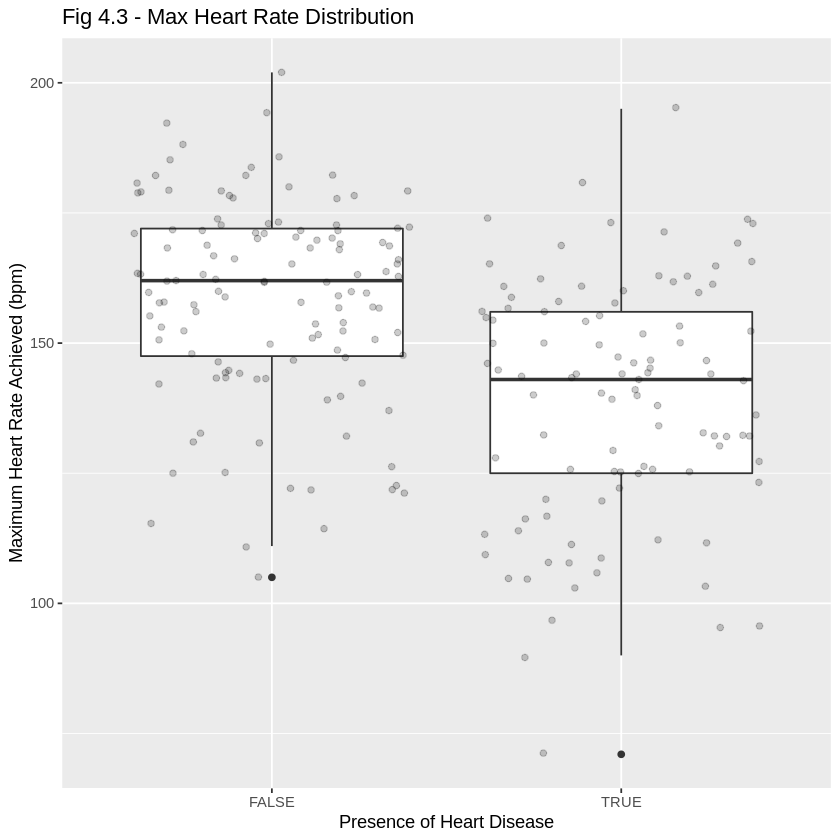

In [10]:
thalach_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = thalach)) +
    geom_boxplot() +
    geom_point(position = "jitter", alpha = 0.2) +
    labs(x = "Presence of Heart Disease", y = "Maximum Heart Rate Achieved (bpm)")+ 
ggtitle("Fig 4.3 - Max Heart Rate Distribution")

thalach_summary_plot

People who have presence of heart disease tend to have lower maximum heart rate achieved compared to people who don't. However, this time, the difference is a lot more significant, indicating a strong correlation. This is a good candidate predictor variable.

#### ST Depression

- The process described above for Max Heart Rate was repeated allow, all the same steps apply. 

In [11]:
average_oldpeak <- cleveland_training |>
    summarize(average_oldpeak = mean(oldpeak))

average_oldpeak_by_type <- cleveland_training |>
    group_by(presence) |>
    summarize(average_oldpeak = mean(oldpeak))
print(" Table 4.4 - Average ST Depression within presence")  
average_oldpeak_by_type
print(" Table 4.5 - Average ST Depression overall")  
average_oldpeak

[1] " Table 4.4 - Average ST Depression within presence"


presence,average_oldpeak
<fct>,<dbl>
FALSE,0.5910569
TRUE,1.5611650


[1] " Table 4.5 - Average ST Depression overall"


average_oldpeak
<dbl>
1.033186


From the dataset, the average ST depression is about 1*mm*. Healthy people have much lower ST depression compared to the sample population and the opposite is true for people with heart disease.

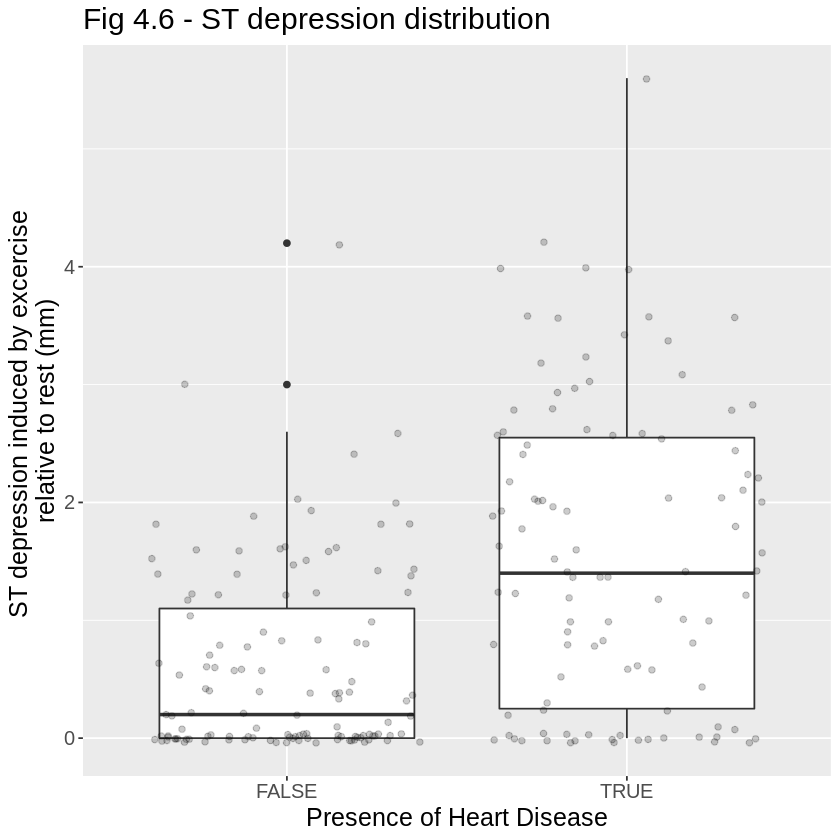

In [12]:
oldpeak_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = oldpeak)) +
    geom_boxplot() +
    geom_point(position = "jitter", alpha = 0.2) +
    labs(x = "Presence of Heart Disease",y = "ST depression induced by excercise \nrelative to rest (mm)") +
    theme(text = element_text(size = 15)) +
    ggtitle("Fig 4.6 - ST depression distribution")

oldpeak_summary_plot

Electrocardiography is the process of producing an electrocardiogram. It is a graph of voltage versus time of the electrical activity of the heart using electrodes placed on the skin. ST depression refers to a finding on an electrocardiogram, wherein the trace in the ST segment is abnormally low below the baseline. We can see that healthy people tend to don't or have ST depression less than 1*mm* compared to sick people. This is a very good candidate as a predictor variable.

## Building the Model

### 5. Choose Predicting Variables
- ST Depression and Max Heart Rate were chosen as predicting variables because we saw the most variation between presence of heart disease and no presence.
- this variation hopefully means that these variables are large contributors to the patients presence of heart disease, making it easier to predict.

### 6.1 Choosing Optimal K Value 

- The training set was tuned using cross validation ($v$ = 5) to find an optimal K value. 
- The accuracy of each k value was plotted in order to choose a k. 
- A range of k values of 1 to 151 was chosen to limit risk of overfitting.  

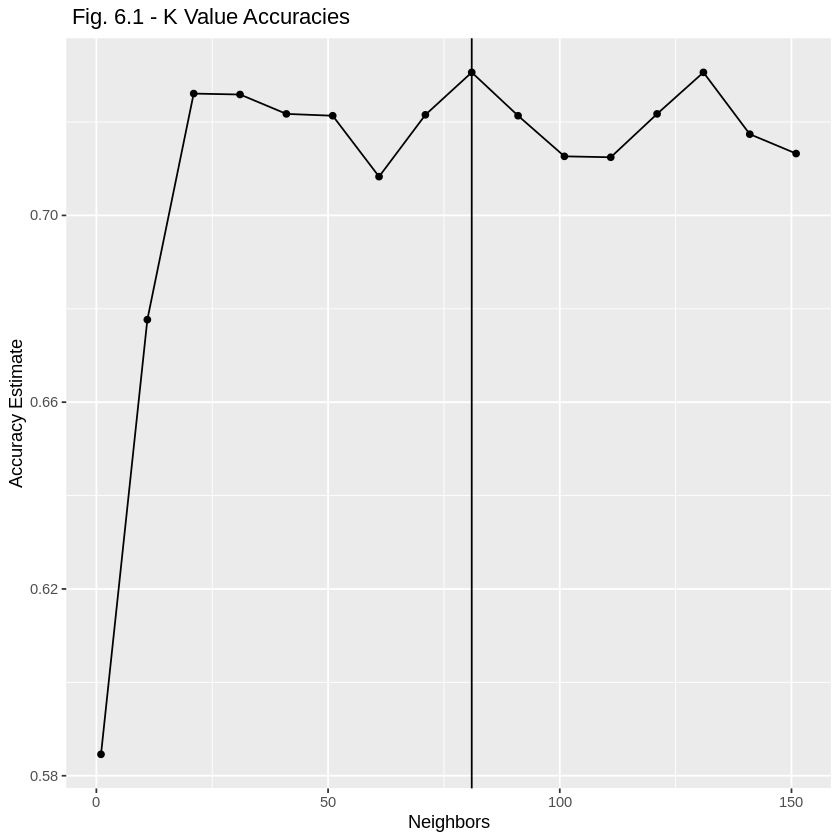

In [13]:
set.seed(8205)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

training_recipe <- recipe(presence ~ thalach + oldpeak, data = cleveland_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

k_value <- tibble(neighbors = seq(from = 1, to = 151, by = 10))

training_fold <- vfold_cv(cleveland_training, v = 5, strata = presence)

training_results <- workflow()|>
    add_recipe(training_recipe)|>
    add_model(knn_tune)|>
    tune_grid(resamples = training_fold, grid = k_value)|>
    collect_metrics()

accuracies <- training_results|>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    geom_vline(xintercept = 81) +
    labs(x="Neighbors", y="Accuracy Estimate") + ggtitle(" Fig. 6.1 - K Value Accuracies")
cross_val_plot

In [14]:
highest_acc <- accuracies |>
    arrange(desc(mean))

print("Table 6.1 K Values with Highest Accuracies")
head(highest_acc)

[1] "Table 6.1 K Values with Highest Accuracies"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
81,accuracy,binary,0.7306324,5,0.02926570,Preprocessor1_Model09
131,accuracy,binary,0.7306324,5,0.02926570,Preprocessor1_Model14
21,accuracy,binary,0.7260870,5,0.02112499,Preprocessor1_Model03
31,accuracy,binary,0.7258893,5,0.02609070,Preprocessor1_Model04
121,accuracy,binary,0.7217391,5,0.03436349,Preprocessor1_Model13
41,accuracy,binary,0.7217391,5,0.02333481,Preprocessor1_Model05


- We have selected k=81 as the optimal value for our final KNN model because it had the highest accuracy and its surrounding k values accuracy did not decrease as significantly compared to choosing k = 131. A higher k such as k=131 would risk overfitting our model. 

### 6.2 Build Final Model 

- new model build with workflow containing k = 81.

In [15]:
set.seed(8205)

cleveland_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 81) |>
       set_engine("kknn") |>
       set_mode("classification")

cleveland_fit <- workflow() |>
       add_recipe(training_recipe) |>
       add_model(cleveland_spec) |>
       fit(data = cleveland_training)
print("Figure 6.2 Final model")
cleveland_fit

[1] "Figure 6.2 Final model"


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(81,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2831858
Best kernel: rectangular
Best k: 81

### 7. Evaluate Final Model 

- We can now evaluate the accuracy of our prediciting model against our testing set.

In [16]:
cleveland_predict<-predict(cleveland_fit, cleveland_testing)|>
    bind_cols(cleveland_testing)

cleveland_metrics<-cleveland_predict |>
    metrics(truth = presence, estimate = .pred_class)|>
    select(.metric, .estimate) |>
    filter(.metric == "accuracy")
print("Table 7.1 Predicted Accuracy of the Model") 
cleveland_metrics

cleveland_confusion<-cleveland_predict|>
    conf_mat(truth = presence, estimate = .pred_class)
print("Table 7.2 Classifier's Confusion Matrix") 
cleveland_confusion

[1] "Table 7.1 Predicted Accuracy of the Model"


.metric,.estimate
<chr>,<dbl>
accuracy,0.7272727


[1] "Table 7.2 Classifier's Confusion Matrix"


          Truth
Prediction FALSE TRUE
     FALSE    35   15
     TRUE      6   21

$$\text{False positive rate} = \frac{6}{6 + 25} = 0.19354... \approx 19.4\% $$
$$\text{False negative rate} = \frac{15}{15 + 21} = 0.41666... \approx 41.7\% $$

# Visualization of Results

We wanted to visualize the areas on the graph that are assigned to the each diagnosis of heart disease. This was achieved by creating data points at every area on the graph and assigning them a prediction to highlight the blue (heart disease) and orange(no heart disease) areas. Then we plotted these highlighting areas with the Cleveland data to create a visual representation of where the predicting model failed to accurately predict the presence of heart disease.

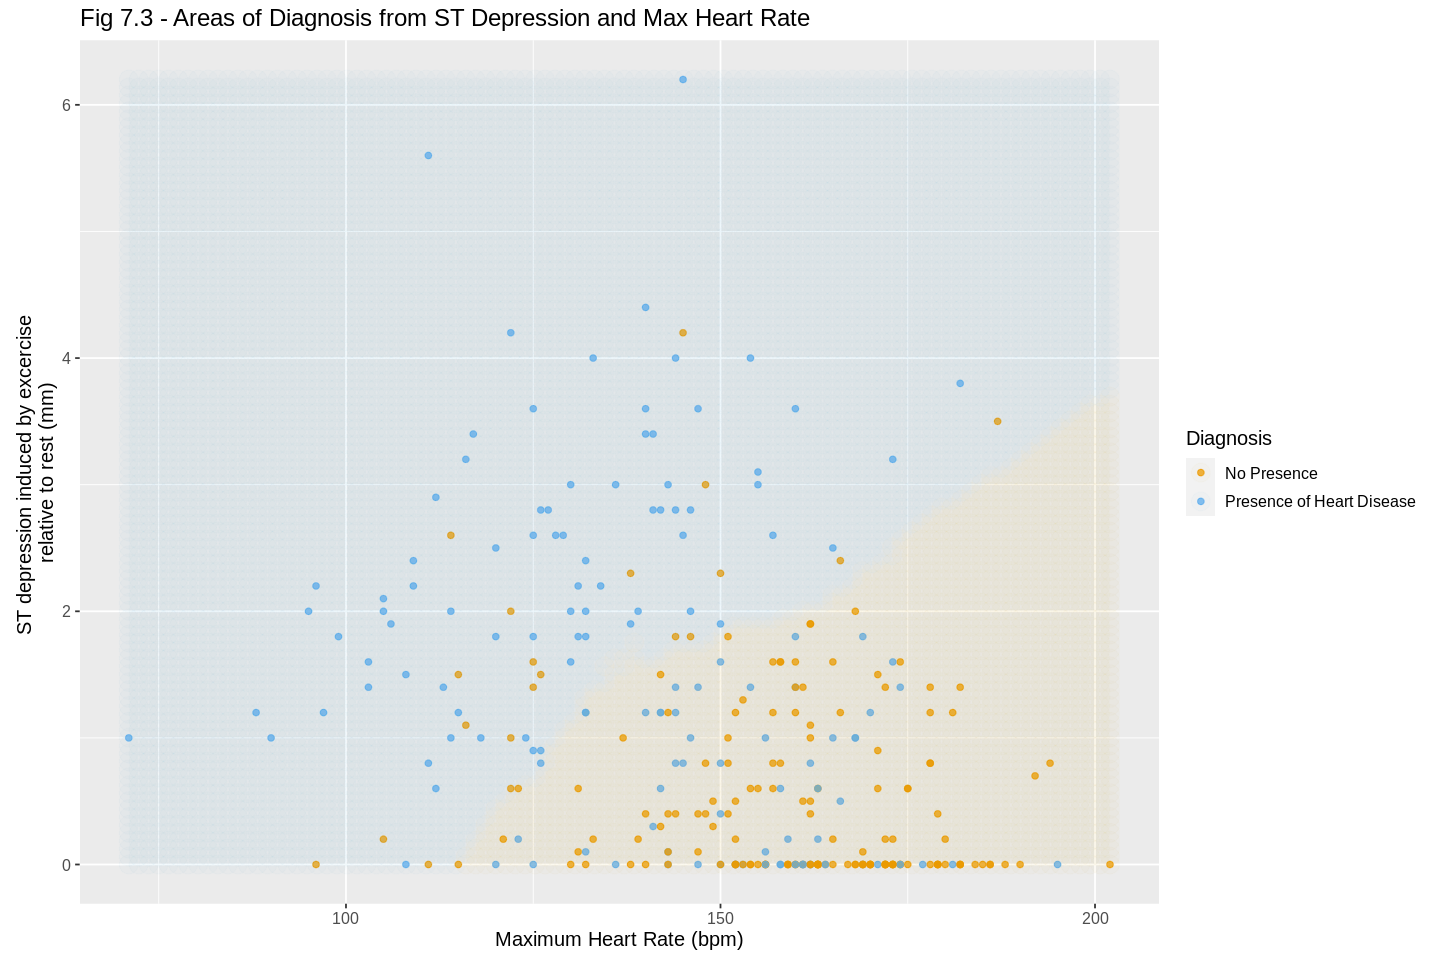

In [17]:
options(repr.plot.height = 8, repr.plot.width = 12)

# Creating data points with predicting variables from max to min for each variable
thalach_grid <- seq(from = min(cleveland_data$thalach), to = max(cleveland_data$thalach), length.out = 100)
oldpeak_grid <- seq(from = min(cleveland_data$oldpeak), to = max(cleveland_data$oldpeak), length.out = 100)

togrid <- as_tibble(expand.grid(thalach = thalach_grid, 
                                oldpeak = oldpeak_grid))

knnPredGrid <- predict(cleveland_fit, togrid)

prediction_table <- bind_cols(knnPredGrid, togrid) |> 
  rename(presence = .pred_class)

cleveland_vis <- ggplot() +
    geom_point(data = cleveland_data, 
               mapping = aes(x = thalach, 
                             y = oldpeak, 
                             color = presence), 
               alpha = 0.75) +
    geom_point(data = prediction_table,         # Highlighting the prediction areas
               mapping = aes(x = thalach, 
                             y = oldpeak, 
                             color = presence), 
               alpha = 0.02, 
               size = 5) +
    labs(color = "Diagnosis", 
         x = "Maximum Heart Rate (bpm)", 
         y = "ST depression induced by excercise \nrelative to rest (mm)") +
    scale_color_manual(labels = c("No Presence", "Presence of Heart Disease"), 
                       values = c("orange2", "steelblue2")) +
    theme(text = element_text(size = 12), aspect.ratio = 0.8)+
    ggtitle("Fig 7.3 - Areas of Diagnosis from ST Depression and Max Heart Rate") 

cleveland_vis

From the plot above, we can see that our classifier split the diagnosis into two distinct regions. It predicted *No Presence* for patients with higher maximum heart rate and lower ST depression. We can also see that there are false positives and negatives but false negatives are much more common.

# Discussion

Around 50% of our data consists of patients with heart disease, which is our majority classifier. Since our accuracy is significantly above the majority classifier, we are confident that our predicting model is extracting useful information. 
The accuracy of our predicting model was 73% which is relatively good considering the size of our data set. This accuracy was expected because of the variability we saw in the predicting variables in our [preliminary data analysis](#Preliminatory-Data-Exploration). If our data set were to contain more observations, our predicting model could be stronger. Our accuracy could be higher if we had used more variables in our predicting model. This accuracy is still high enough to have useful applications in health care. While it may not predict the presence of heart disease 100% of the time, it can give us a better idea of the patient's risk of heart disease. Our confusion matrix [(Table 7.2)](#7.-Evaluate-Final-Model), shows us that we have more false negatives than false positives. This can be dangerous because leaving heart disease untreated can be detrimental. Therefore, our predicting model could be used as a suggestion or an initial guess, but the patient should be further assessed before a final diagnosis. Although, our model can still have positive societal applications with possible early diagnosis which could possibly save the patients life. It is always optimal to treat a disease early on before becoming detrimental to the patient which could be avoided with the use of our model. 

Some questions that have arisen after our final assessments of the model are, what additional variables could be added to optimise predicting accuracy? Would this combination still include ST Depression and Heart Disease? Are there other variables outside of our dataset that are better for predicting heart disease? These questions could be answered with larger datasets, with many more observations and additional columns in order to create the most accurate predicting model possible. 


# References

- Tiffany Timbers, T. C. (2022, September 24). Data science. Chapter 5 Classification I: training & predicting. Retrieved April 6, 2023, from https://datasciencebook.ca/classification1.html 
- World Health Organization. (n.d.). Cardiovascular diseases. World Health Organization. Retrieved April 6, 2023, from https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1 
- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
